<a href="https://colab.research.google.com/github/MaksimMaxim/demo16.11/blob/main/%D0%90%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7_%D1%80%D1%8B%D0%BD%D0%BE%D1%87%D0%BD%D0%BE%D0%B9_%D0%BA%D0%BE%D1%80%D0%B7%D0%B8%D0%BD%D1%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Итоговая аттестация.

Проект 7

**Анализ рыночной корзины и ассоциативные правила на основе клиентских данных**

In [ ]:
#подключение к гугл_диску
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from tabulate import tabulate
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

In [ ]:
#загрузка данных
df_original = pd.read_excel('/content/drive/MyDrive/Attestation/electronika_03_04 (1 по 14 марта) (1).xlsx')

# Предварительный анализ данных.

In [ ]:
#!!! создадим рабочую копию исходного датафрейм для последующего преобразования, чтобы не "трогать" первоначальные данные.
df=df_original

In [ ]:
#кол-во строк и столбцов таблицы (92937*37)
df.shape

(92937, 37)

In [ ]:
#наименования столбцов таблицы
cols = df.columns
for i in range(len(cols)):
  print(cols[i])

Order_ID
Email_new
Phone_new
Source
OrderDate
время
месяц
ChangeDate
DeliveryDate
PaymentDate
Status
Status_ID
OneClick
CancelReason
Actions
DeliveryType
PaymentType
Region
Area
Store_ID
FullSum
Discount
IM_Rozn_Sum
Row_ID
Articul
Nom_Name
NomGroup
Quant
RowPrice
RowDiscount
RowSum
Brand
TN
TK
NomFullPath
Week
Nom_ID


Для каждого столбца выведем: количество уникальных значений, нулевых, NaNs и их долю, а также тип данных в столбцах.

In [ ]:
def columnValues(df):
    row = [df.nunique(), (df == 0).sum(axis=0), df.isna().sum(), round(df.isna().sum() / len(df) * 100, 1), df.dtypes]
    return row

data = []
for column in df:
    data.append([column] + columnValues(df[column]))

print(tabulate(data, headers=['Column', 'Count Unique', 'Count Zeros', 'Count NaNs','% of NaNs', 'data type'], tablefmt='orgtbl'))

| Column       |   Count Unique |   Count Zeros |   Count NaNs |   % of NaNs | data type      |
|--------------+----------------+---------------+--------------+-------------+----------------|
| Order_ID     |          44139 |             0 |            0 |         0   | object         |
| Email_new    |          29547 |         12600 |            0 |         0   | object         |
| Phone_new    |          35031 |          1699 |            0 |         0   | object         |
| Source       |              4 |             0 |            0 |         0   | object         |
| OrderDate    |             14 |             0 |            0 |         0   | datetime64[ns] |
| время        |          30977 |             0 |            0 |         0   | object         |
| месяц        |              1 |             0 |            0 |         0   | int64          |
| ChangeDate   |          41147 |             0 |            0 |         0   | object         |
| DeliveryDate |             54 |       

*Столбцы Email_new и Phone_new содержат схожие данные, идентифицирующие покупателя. Оставляем столбец с номерами телефонов, так как он содержит гораздо меньше нулевых значений (1699), в то время как столбец с электронными адресами - 12600 нулевых значений. При этом номера телефонов по электронным адресам нельзя никак идентифицировать, т.к. у покупателей с "нулевыми" номерами телефонов e-mail также не указан. Следовательно, столбец Email_new и строки с "нулевыми" номерами телефонов необходимо удалить.*

In [ ]:
#удаление столбца Email_new.
df = df.drop(columns=['Email_new'])

In [ ]:
df.shape

(92937, 36)

In [ ]:
#удаление строк с нулевыми номерами телефонов.
df = df.loc[df['Phone_new'] != 0]

In [ ]:
df.shape

(91238, 36)

In [ ]:
#удаляем чеки, в которых присутствуют отрицательные скидки (возможные ошибки системы)
df = df.loc[~df['Order_ID'].isin(['1303000511'])]

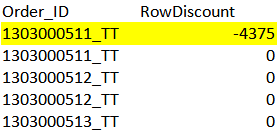

In [ ]:
df.shape

(91238, 36)

In [ ]:
#удаляем строки с нулевыми значениями RowSum, т.к. нам не нужны "бесплатные" товары
df = df.loc[df['RowSum'] != 0]

In [ ]:
df.shape

(51907, 36)

In [ ]:
#посмотрим долю скидки от реальной стоимости по товарам, записываем в дополнительно созданный столбец DiscountPercent
df['DiscountPercent'] = df['RowDiscount'] / (df['RowSum'] + df['RowDiscount'])

In [ ]:
#удаляем строки со скидкой более 90%
df = df.loc[df['DiscountPercent'] < 0.9]

In [ ]:
df.shape

(51904, 37)

In [ ]:
#DiscountPercent нам больше не нужен, удаляем
#из временнЫх столбцов оставляем только месяц OrderMonth (месяц)
#удаляем "лишние столбцы", не несущие существенной инф-ции для дальнейшего анализа
#FullSum пока оставляем, он нужен будет дальше для расчета среднего чека
#Actions (вид скидки), Discount (сумма скидки по чеку) удаляем, RowDiscount оставляем (содержит данные по скидкам в разрезе товаров)
#NomFullPath - слишком подробная разбивка на категории, оставляем категории TN и TK
#Area удаляем, оставляем Region

df = df.drop(columns=['OrderDate', 'ChangeDate', 'DeliveryDate', 'Status_ID', 'OneClick', 'Actions', 
                      'DeliveryType', 'Area', 'Store_ID', 'Discount', 'IM_Rozn_Sum', 'Row_ID', 'Articul',
                      'Brand', 'NomFullPath', 'Week', 'Nom_ID', 'DiscountPercent'])

In [ ]:
df.shape

(51904, 19)

In [ ]:
# покажи уникальные значения причины отмены
df.CancelReason.unique()

array(['Клиент не пришел за заказом', 'Тестовый заказ',
       'Нет связи с клиентом', nan, 'Нет партнерского товара',
       'Витринный образец/Брак товара', 'Несколько заказов',
       'Клиент передумал', 'Не поступила оплата',
       'Нарушение сроков доставки', 'Купил в магазине',
       'Дублирование заказа',
       'Клиент отказался назвать причину  отмены заказа',
       'Не устроила дата доставки',
       'Не устроила дата доставки партнерского товара', 'Нет товара',
       'Не устроила цена', 'Не устроила цена партнерского товара',
       'Не устроили характеристики товара', 'Неполные данные в заказе',
       'Дублирование заказа техническое', 'Другое (указать в примечании)',
       'Негативные отзывы о товара', 'Отказ при осмотре',
       'Ошибка в модели', 'Отказ в выдаче кредита',
       'Не устроил срок обработки заказа', 'Качество товара',
       'Витрина/брак/некондиция/качество товара',
       'Не устроило время доставки', 'Негативные отзывы о компании',
       'Не устр

In [ ]:
#удаляем строки с ошибками, дублированными и тестовыми заказами
# (CancelReason - причина отмены заказа)
df = df.loc[~df['CancelReason'].isin(['Тестовый заказ', 'nan','Несколько заказов', 'Дублирование заказа',
                  'Дублирование заказа техническое', 'Ошибка в модели'])]

In [ ]:
df.shape

(50516, 19)

In [ ]:
# покажи уникальные значения текущего статуса
df.Status.unique()

array(['Отменен', 'Выдан клиенту', 'Отказ на месте',
       'Доставлен в магазин', 'Доставлен частично в магазин',
       'Согласован', 'Собран', 'В обработке'], dtype=object)

In [ ]:
#по столбцу Status также можно исключить дублированные заказы
df = df.loc[~df['Status'].isin(['Дубль заказа'])]

In [ ]:
df.shape

(50516, 19)

In [ ]:
#ищем в столбце NomGroup все услуги (при этом создаем вспомогательный датафрейм со значениями, содержащими "услуг")
df_1= df[df['NomGroup'].str.contains('услуг', regex=False, case=False, na=False)]
df_1.NomGroup.unique()

array([], dtype=object)

In [ ]:
#удаляем товары из категории NomGroup - Услуги
df = df.loc[df['NomGroup'] != 'Услуги']

In [ ]:
df.shape

(50516, 19)

In [ ]:
#по столбцу NomGroup удаляем все доставки
df_2= df[df['NomGroup'].str.contains('достав', regex=False, case=False, na=False)]
df_2.NomGroup.unique()

array(['Доставка'], dtype=object)

In [ ]:
df = df.loc[df['NomGroup'] != 'Доставка']

In [ ]:
df.shape

(47807, 19)

*Столбцы Region перезаполняем наименованиями соответствующих федеральных округов.*

In [ ]:
df['Region'] = df['Region'].replace(['Москва', 'Белгород', 'Владимир', 'Воронеж', 'Иваново', 'Калуга', 'Кострома', 'Курск', 'Липецк', 'Люберцы', 'Мытищи', 
                                     'Подольск', 'Рязань', 'Сергиев Посад', 'Серпухов', 'Смоленск', 'Тамбов', 'Тверь', 'Тула', 'Ярославль'], 'Центральный ф.о.')
df['Region'] = df['Region'].replace(['Великий Новгород', 'Вологда', 'Воркута', 'Всеволожск', 'Выборг', 'Гатчина', 'Кингисепп', 'Кириши', 'Колпино', 'Мурманск', 
                                     'Петрозаводск', 'Псков', 'Пушкин', 'Санкт-Петербург', 'Тихвин', 'Череповец'], 'Северо-Западный ф.о.')
df['Region'] = df['Region'].replace(['Ижевск', 'Казань', 'Набережные Челны', 'Нижний Новгород', 'Новокуйбышевск', 'Пенза', 'Пермь', 'Самара', 'Саратов', 
                                     'Тольятти', 'Ульяновск', 'Уфа', 'Чебоксары'], 'Приволжский ф.о.')
df['Region'] = df['Region'].replace(['Барнаул', 'Горно-Алтайск', 'Иркутск', 'Кемерово', 'Красноярск', 'Новокузнецк', 'Новосибирск', 'Омск', 'Томск'], 'Сибирский ф.о.')
df['Region'] = df['Region'].replace(['Волгоград', 'Краснодар', 'Новочеркасск', 'Пятигорск', 'Ростов-на-Дону', 'Сочи', 'Ставрополь'], 'Южный ф.о.')
df['Region'] = df['Region'].replace(['Екатеринбург', 'Нижневартовск', 'Нижний Тагил', 'Ноябрьск', 'Сургут', 'Тюмень', 'Челябинск'], 'Уральский ф.о.')

<ipython-input-33-3ae6497ffe16>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Region'] = df['Region'].replace(['Москва', 'Белгород', 'Владимир', 'Воронеж', 'Иваново', 'Калуга', 'Кострома', 'Курск', 'Липецк', 'Люберцы', 'Мытищи',
<ipython-input-33-3ae6497ffe16>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Region'] = df['Region'].replace(['Великий Новгород', 'Вологда', 'Воркута', 'Всеволожск', 'Выборг', 'Гатчина', 'Кингисепп', 'Кириши', 'Колпино', 'Мурманск',


In [ ]:
df['Region'] = df['Region'].replace({'Владивосток': 'Дальневосточный ф.о.'})

In [ ]:
# После переназначения делаем уникальные значения 
df.Region.unique()

array(['Центральный ф.о.', 'Северо-Западный ф.о.', 'Сибирский ф.о.',
       'Приволжский ф.о.', 'Уральский ф.о.', 'Южный ф.о.',
       'Дальневосточный ф.о.'], dtype=object)

In [ ]:
df.shape

(47807, 19)

In [ ]:
#промежуточный просмотр наших данных после произведенных преобразований

def columnValues(df):
    row = [df.nunique(), (df == 0).sum(axis=0), df.isna().sum(), round(df.isna().sum() / len(df) * 100, 1), df.dtypes]
    return row

data_1 = []
for column in df:
    data_1.append([column] + columnValues(df[column]))

print(tabulate(data_1, headers=['Column', 'Count Unique', 'Count Zeros', 'Count NaNs','% of NaNs', 'data type'], tablefmt='orgtbl'))

| Column       |   Count Unique |   Count Zeros |   Count NaNs |   % of NaNs | data type   |
|--------------+----------------+---------------+--------------+-------------+-------------|
| Order_ID     |          42139 |             0 |            0 |         0   | object      |
| Phone_new    |          34876 |             0 |            0 |         0   | object      |
| Source       |              4 |             0 |            0 |         0   | object      |
| время        |          30078 |             0 |            0 |         0   | object      |
| месяц        |              1 |             0 |            0 |         0   | int64       |
| PaymentDate  |          27219 |             0 |            0 |         0   | object      |
| Status       |              8 |             0 |            0 |         0   | object      |
| CancelReason |             27 |             0 |        31723 |        66.4 | object      |
| PaymentType  |              7 |             0 |            0 |      

In [ ]:
#выгрузка предварительной таблицы
df.to_excel('df_first.xlsx', index=False)

*Исследуем более подробно столбцы TN и Nom_Name. При просмотре выгруженной предварительной таблицы выявлено, что пропущенные значения TN - это различные услуги по установке, настройке и др. Их необходимо исключить.*

In [ ]:
df_3= df[df['Nom_Name'].str.contains('устан', regex=False, case=False, na=False)]
df_3.Nom_Name.unique()

array(['Подкл.стир.,посудом.машин станд.устан.',
       'Станд.установ.газ.плиты отдельностоящей',
       'Установка холод.б/дораб.коммун+перев.дв',
       'Установка напольного унитаза', 'Станд.установ.дух шкафа газ.',
       'Станд.установ.вар.поверх.газ.',
       'Подкл.накоп.водонаг.бол.30л ст.устан'], dtype=object)

In [ ]:
df = df.loc[~df['Nom_Name'].isin(['Подкл.стир.,посудом.машин станд.устан.',
       'Станд.установ.газ.плиты отдельностоящей',
       'Установка холод.б/дораб.коммун+перев.дв',
       'Установка напольного унитаза', 'Станд.установ.дух шкафа газ.',
       'Станд.установ.вар.поверх.газ.',
       'Подкл.накоп.водонаг.бол.30л ст.устан',
       'Установка Bosch PLS 300+PTC 1 0603B04100',
       'Станд.установ.кондиц.(модели 5,7,9,10)',
       'Установочный набор Mystery MAK 2.08',
       'Установка смесителя на гибкой подводке',
       'Станд.установ.кондиц.(модели 12,13,14)'])]

In [ ]:
df.shape

(47747, 19)

In [ ]:
df_4= df[df['Nom_Name'].str.contains('подк', regex=False, case=False, na=False)]
df_4.Nom_Name.unique()

array(['Подкл.стир.,посудом.машин с частич.дораб',
       'Подкл.встр.СМА,ПМ/маш к готов.коммун', 'Подкл. варочной панели',
       'Подкл. духового шкафа', 'ТВ-модуль АКАДО Телеком Подключи сам!',
       'Подкл.холодильника: б/дораб.коммуникаций',
       'Подкл.СМА,посудом.с доработкой сантех',
       'Подкл. эл.плиты отдельностоящей',
       'Подкл.встр.СМА,ПМ/маш с дораб.сантех+эл',
       'Подключение GROHE Euphoria Cube 27704000'], dtype=object)

In [ ]:
df = df.loc[~df['Nom_Name'].isin(['Подкл.стир.,посудом.машин с частич.дораб',
       'Подкл.встр.СМА,ПМ/маш к готов.коммун', 'Подкл. варочной панели',
       'Подкл. духового шкафа',
       'Подкл.холодильника: б/дораб.коммуникаций',
       'Подкл.СМА,посудом.с доработкой сантех',
       'Подкл. эл.плиты отдельностоящей',
       'Подкл.встр.СМА,ПМ/маш с дораб.сантех+эл',
       'Подключение GROHE Euphoria Cube 27704000',
       'Подкл.СМА,посудом.с дораб.сантех+электр.',
       'Подкл.варочной панели и духового шкафа',
       'Подкл. холодильника встраив.',
       'Крепление LCD-телевизора на стену, подключение, настройка и сортировка каналов (размер диагонали 41-47")',
       'Подкл.накоп.водонаг.до 30л с доработк.',
       'Подключение GROHE Relexa 28628000',
       'Подкл.накоп.водонаг.бол.30л с дораб',
       'Подкл.холод Side by Side дораб.коммун.',
       'Подключение GROHE Relexa 28671000',
       'Подключение стиральной машины (Эконом)',
       'Крепление LCD-телевизора на стену, подключение, настройка и сортировка каналов (размер диагонали 33-40")'])]

In [ ]:
df.shape

(47703, 19)

In [ ]:
df_5= df[df['Nom_Name'].str.contains('сборк', regex=False, case=False, na=False)]
df_5.Nom_Name.unique()

array(['Сборка мебели от стоимости от 0-12000',
       'Сборка мебели от стоимости от 12001-24000'], dtype=object)

In [ ]:
df = df.loc[~df['Nom_Name'].isin(['Сборка мебели от стоимости от 0-12000',
       'Сборка мебели от стоимости от 12001-24000',
       'Сборка мебели и тумб для ПК и ТВ'])]

In [ ]:
df.shape

(47689, 19)

In [ ]:
df_6= df[df['Nom_Name'].str.contains('сервис', regex=False, case=False, na=False)]
df_6.Nom_Name.unique()

array(['Программа дополнительного сервисного обслуживания Сервис + на 2 года',
       'Программа дополнительного сервисного обслуживания Сервис + на 1 год',
       'Программа дополнительного сервисного обслуживания Сервис + на 3 года'],
      dtype=object)

In [ ]:
df = df.loc[~df['Nom_Name'].isin(['Программа дополнительного сервисного обслуживания Сервис + на 2 года',
       'Программа дополнительного сервисного обслуживания Сервис + на 1 год',
       'Программа дополнительного сервисного обслуживания Сервис + на 3 года',
       'Сервис+2.0 на 1 год', 'Сервис+2.0 на 2 года',
       'Сервис+2.0 на 3 года'])]

In [ ]:
df.shape

(47631, 19)

In [ ]:
df_7= df[df['Nom_Name'].str.contains('настро', regex=False, case=False, na=False)]
df_7.Nom_Name.unique()

array(['Набор Bonita Настроение 20100212661',
       'Настройка LCD-телевизора, сортировка каналов'], dtype=object)

In [ ]:
df = df.loc[~df['Nom_Name'].isin(['Набор Bonita Настроение 20100212661',
       'Настройка LCD-телевизора, сортировка каналов'])]

In [ ]:
df.shape

(47629, 19)

In [ ]:
df_8= df[df['Nom_Name'].str.contains('поли', regex=False, case=False, na=False)]
df_8.Nom_Name.unique()

array(['Полировщик Bellissima 5154 д/ногтей',
       'Игрушка SIKU Тягач с вертолетом. полиц.',
       'Каталка Italtrike Полицейская машина гол',
       'Полис Ринко "Защита МАКС"',
       'Набор Welly Военно-полицейская команда'], dtype=object)

In [ ]:
df = df.loc[~df['Nom_Name'].isin(['Игрушка SIKU Тягач с вертолетом. полиц.',
       'Каталка Italtrike Полицейская машина гол',
       'Полис Ринко "Защита МАКС"',
       'Набор Welly Военно-полицейская команда'])]

In [ ]:
df_9= df[df['Nom_Name'].str.contains('креп', regex=False, case=False, na=False)]
df_9.Nom_Name.unique()

array(['Крепления Rottefella NNN Exer.Skat.NIS ч',
       'Крепления Fischer NNN Perf.Clas.NIS ч/б',
       'Крепления Winter Dream NNN Flash',
       'Крепления Rottefella NNN Exer.Clas.NIS ч',
       'Крепления Rottefella NNN Tour.Auto Com.с',
       'Крепления No Name NNN Light Snow',
       'Крепления No Name 75мм черный', 'Крепления Snowmatic SNS 321341',
       'Крепления No Name 75мм белый', 'Крепления Snowmatic NNN 311341',
       'Крепления Fischer NNN Entry Lot', 'Крепления Winter Dream NNN',
       'Крепления Fischer NNN Perf.Clas.NIS ч/ж',
       'Турник No Name 118 см с доп. креплением', 'Крепления Karjala NNN'],
      dtype=object)

In [ ]:
df = df.loc[~df['Nom_Name'].isin(['Крепления Rottefella NNN Exer.Skat.NIS ч',
       'Крепления Fischer NNN Perf.Clas.NIS ч/б',
       'Крепления Winter Dream NNN Flash',
       'Крепления Rottefella NNN Exer.Clas.NIS ч',
       'Крепления Rottefella NNN Tour.Auto Com.с',
       'Крепления No Name NNN Light Snow',
       'Крепления No Name 75мм черный', 'Крепления Snowmatic SNS 321341',
       'Крепления No Name 75мм белый', 'Крепления Snowmatic NNN 311341',
       'Крепления Fischer NNN Entry Lot', 'Крепления Winter Dream NNN',
       'Крепления Fischer NNN Perf.Clas.NIS ч/ж',
       'Турник No Name 118 см с доп. креплением', 'Крепления Karjala NNN'])]

In [ ]:
df.shape

(47585, 19)

In [ ]:
#после просмотра получившейся таблицы выявлены еще несколько услуг, которые можно исключить
df_9= df[df['Nom_Name'].str.contains('гарант', regex=False, case=False, na=False)]
df_9.Nom_Name.unique()

array(['«Гарант +» - Договор страхования, обеспечивающий защиту техники от негарантийной поломки, механического повреждения'],
      dtype=object)

In [ ]:
df = df.loc[~df['Nom_Name'].isin(['«Гарант +» - Договор страхования, обеспечивающий защиту техники от негарантийной поломки, механического повреждения'])]

In [ ]:
df_10= df[df['Nom_Name'].str.contains('навес', regex=False, case=False, na=False)]
df_10.Nom_Name.unique()

array(['Навес вытяжки кам.типа б/воздуховода',
       'Навес вытяжки встраив. б/воздуховода'], dtype=object)

In [ ]:
df = df.loc[~df['Nom_Name'].isin(['Навес вытяжки кам.типа б/воздуховода',
       'Навес вытяжки встраив. б/воздуховода'])]

In [ ]:
df_11= df[df['Nom_Name'].str.contains('монтаж', regex=False, case=False, na=False)]
df_11.Nom_Name.unique()

array([], dtype=object)

In [ ]:
df = df.loc[~df['Nom_Name'].isin(['Гарантийный талон Bosch (эл.инструмент)',
       '«Гарант +» - Договор страхования, обеспечивающий защиту техники от негарантийной поломки, механического повреждения', 
       'Навес вытяжки кам.типа б/воздуховода', 'Навес вытяжки встраив. б/воздуховода',
       'Навес вытяжки плоской б/воздуховода', 'АКЦИЯ! Монтаж спутниковой антенны до 89см на балкон'])]

In [ ]:
df.shape

(47575, 19)

In [ ]:
df_12= df[df['Nom_Name'].str.contains('Сим-карта', regex=False, case=False, na=False)]
df_12.Nom_Name.unique()

array(['Сим-карта Мегафон ИнтернетБезЗабот мск'], dtype=object)

In [ ]:
df = df.loc[~df['Nom_Name'].isin(['Сим-карта Мегафон ИнтернетБезЗабот мск'])]

In [ ]:
df_13= df[df['Nom_Name'].str.contains('Подар', regex=False, case=False, na=False)]
df_13.Nom_Name.unique()

array(['Чайник Ariete 2891 (подарок)',
       'Фен Polaris PHD 2249LTi (подарок)',
       'Подарочная карта 500 руб с конвертом',
       'Термокружка Vitek VT-1520 (подарок)'], dtype=object)

In [ ]:
df = df.loc[~df['Nom_Name'].isin(['Фен Polaris PHD 2249LTi (подарок)',
       'Подарочная карта 500 руб с конвертом',
       'Термокружка Vitek VT-1520 (подарок)','Чайник Ariete 2891 (подарок)'])]

In [ ]:
def columnValues(df):
    row = [df.nunique(), (df == 0).sum(axis=0), df.isna().sum(), round(df.isna().sum() / len(df) * 100, 1), df.dtypes]
    return row

data_3 = []
for column in df:
    data_3.append([column] + columnValues(df[column]))

print(tabulate(data_3, headers=['Column', 'Count Unique', 'Count Zeros', 'Count NaNs','% of NaNs', 'data type'], tablefmt='orgtbl'))

| Column       |   Count Unique |   Count Zeros |   Count NaNs |   % of NaNs | data type   |
|--------------+----------------+---------------+--------------+-------------+-------------|
| Order_ID     |          42093 |             0 |            0 |         0   | object      |
| Phone_new    |          34839 |             0 |            0 |         0   | object      |
| Source       |              4 |             0 |            0 |         0   | object      |
| время        |          30049 |             0 |            0 |         0   | object      |
| месяц        |              1 |             0 |            0 |         0   | int64       |
| PaymentDate  |          27198 |             0 |            0 |         0   | object      |
| Status       |              8 |             0 |            0 |         0   | object      |
| CancelReason |             27 |             0 |        31566 |        66.4 | object      |
| PaymentType  |              7 |             0 |            0 |      

In [ ]:
df.shape

(47552, 19)

In [ ]:
#удаление строк с товарами дешевле 200 руб. (это различные батарейки, салфетки, ложки и др.)
df = df.loc[df['RowPrice'] > 200]

In [ ]:
df.shape

(46897, 19)

In [ ]:
# столбец с ценами RowPrice нам больше не нужен
df = df.drop(columns=['RowPrice'])

In [ ]:
#способы оплаты сократим до предоплаты онлайн и постоплаты (карта и наличные при получении)
df.PaymentType.unique()

array(['Наличные', 'КартойПриПолучении', 'RBK Money', 'Кредит в магазине',
       'PayPal', 'Квитанция Сбербанка', 'Банк Тинькофф'], dtype=object)

In [ ]:
df['PaymentType'] = df['PaymentType'].replace({'КартойПриПолучении': 'при получении', 'Наличные': 'при получении',
                                               'PayPal': 'предоплата онлайн', 'Квитанция Сбербанка': 'предоплата онлайн',
                                               'RBK Money': 'предоплата онлайн', 'Кредит в магазине': 'предоплата онлайн',
                                               'Банк Тинькофф': 'предоплата онлайн', })


In [ ]:
df.TK.unique()

array(['Хозтовары', 'Телевизоры LCD', 'Картриджи и бумага', 'Плиты',
       'Приготовление пищи', 'Портативная электроника',
       'Красота и здоровье', 'Музыкальные инструменты', 'Электропитание',
       'Мобильные средства связи', 'Гостиная', 'Игрушки',
       'Велосипеды и аксессуары',
       'Аксессуары для комп./ноутбуков/принтеров', 'Планшеты', 'Фитнес',
       'Силовая и садовая техника', 'Инструменты', 'Встраиваемая техника',
       'Автоэлектроника', 'Швейная техника', 'Стиральные машины',
       'Уход за домом', 'Сантехника', 'Холодильное оборудование',
       'Компьютеры настольные', 'Аксессуары для смартфонов и планшетов',
       'Товары для кухни', 'Прихожая', 'Вентиляторы бытовые',
       'Увлажнители', 'Игровые консоли', 'Посудомоечные машины',
       'Офис и Кабинет', 'Носители информации', 'Прогулки и путешествие',
       'Аксессуары для мебели', 'Периферийные устройства', 'Туризм',
       'Тренажеры', 'Аксессуары для бытовой техники', 'СВЧ',
       'Водонагреватели',

In [ ]:
#по столбцу TK исключаем подарки магазина, Услуги по пластиковым картам (подарочные сертификаты), упаковку и контракты с сотовыми и ТВ операторами
df = df.loc[~df['TK'].isin(['Подарки МБТ', 'Подарки КБТ', 'Услуги по пластиковым картам', 'Упаковка', 'Контракты сотовой связи и НТВ+'])]

In [ ]:
df.shape

(46877, 18)

In [ ]:
def columnValues(df):
    row = [df.nunique(), (df == 0).sum(axis=0), df.isna().sum(), round(df.isna().sum() / len(df) * 100, 1), df.dtypes]
    return row

data_4 = []
for column in df:
    data_4.append([column] + columnValues(df[column]))

print(tabulate(data_4, headers=['Column', 'Count Unique', 'Count Zeros', 'Count NaNs','% of NaNs', 'data type'], tablefmt='orgtbl'))

| Column       |   Count Unique |   Count Zeros |   Count NaNs |   % of NaNs | data type   |
|--------------+----------------+---------------+--------------+-------------+-------------|
| Order_ID     |          41770 |             0 |            0 |         0   | object      |
| Phone_new    |          34634 |             0 |            0 |         0   | object      |
| Source       |              4 |             0 |            0 |         0   | object      |
| время        |          29880 |             0 |            0 |         0   | object      |
| месяц        |              1 |             0 |            0 |         0   | int64       |
| PaymentDate  |          27006 |             0 |            0 |         0   | object      |
| Status       |              8 |             0 |            0 |         0   | object      |
| CancelReason |             27 |             0 |        31108 |        66.4 | object      |
| PaymentType  |              2 |             0 |            0 |      

In [ ]:
df.Source.unique()

array(['Онлайн-Резерв.', 'Колл-центр', 'Сайт', 'Терминал'], dtype=object)

In [ ]:
df_reserved = df #сохранение данных по размещенным заказам (вдруг пригодится)

In [ ]:
df_reserved.to_excel('df_reserved.xlsx', index=False) #таблица с размещенными заказами (только товары, без вспомогательных услуг)

# РАСЧЕТ СВОДНЫХ ПОКАЗАТЕЛЕЙ (выручка, выкупаемость, средний чек и др.)

In [ ]:
#функция расчета среднего значения
def MeanValue(i):
    df.groupby(['Order_ID']) #номер чека
    return i.mean()

In [ ]:
#функция агрегации для расчета сводных данных (выручка, средний чек, кол-во уникальных клиентов и товаров и др. )
agg_func = {'RowSum': ['sum'], #сумма выручки по всем товарам
            'Order_ID': ['nunique'], #кол-во уникальных чеков
            'Phone_new': ['nunique'], #кол-во уникальных клиентов
            'FullSum': [MeanValue], #средний чек
            'Quant': [MeanValue, 'sum'], #к-во товаров (среднее и общее)
            'TN': ['nunique'], #кол-во уникальных категорий в TN 
            'TK': ['nunique']} #кол-во уникальных категорий в TK 

In [ ]:
#размещенные заказы
df_Order = df.groupby(['месяц']).agg(agg_func)
df_Order

RowSum Order_ID Phone_new       FullSum     Quant             TN  \
              sum  nunique   nunique     MeanValue MeanValue    sum nunique   
месяц                                                                         
201603  452521418    41770     34634  12057.810105  1.056403  49521      14   

            TK  
       nunique  
месяц           
201603      98

In [ ]:
#выкупленные товары
df_Paid = df[df['Status'] == 'Выдан клиенту'].groupby(['месяц']).agg(agg_func)
df_Paid

RowSum Order_ID Phone_new       FullSum     Quant             TN  \
              sum  nunique   nunique     MeanValue MeanValue    sum nunique   
месяц                                                                         
201603  266450656    27853     25029  10480.626664   1.03895  32382      14   

            TK  
       nunique  
месяц           
201603      97

In [ ]:
#процент выкупа
df_ProcentPaid = (df_Paid/df_Order)
df_ProcentPaid

RowSum  Order_ID Phone_new   FullSum     Quant                TN  \
             sum   nunique   nunique MeanValue MeanValue       sum nunique   
месяц                                                                        
201603  0.588813  0.666818  0.722671  0.869198  0.983479  0.653904     1.0   

              TK  
         nunique  
месяц             
201603  0.989796

**Окончательная подготовка данных для сегментации (оставляем только выданные заказы, удаляем лишние столбцы)**

In [ ]:
#столбец со статусами заказов
df.Status.unique()

array(['Отменен', 'Выдан клиенту', 'Отказ на месте',
       'Доставлен в магазин', 'Доставлен частично в магазин',
       'Согласован', 'Собран', 'В обработке'], dtype=object)

In [ ]:
#оставляем только строки с выданными заказами
df = df[~df['Status'].isin(['Выдан клиенту'])]

In [ ]:
df.shape

(15709, 18)

In [ ]:
#исследуем столбец с причинами отказов
df.CancelReason.unique()

array(['Клиент не пришел за заказом', 'Нет связи с клиентом',
       'Нет партнерского товара', 'Витринный образец/Брак товара',
       'Клиент передумал', 'Не поступила оплата',
       'Нарушение сроков доставки',
       'Клиент отказался назвать причину  отмены заказа',
       'Купил в магазине', 'Не устроила дата доставки',
       'Не устроила дата доставки партнерского товара', 'Нет товара',
       'Не устроила цена', 'Не устроила цена партнерского товара',
       'Не устроили характеристики товара', 'Неполные данные в заказе',
       'Другое (указать в примечании)', 'Негативные отзывы о товара', nan,
       'Отказ при осмотре', 'Отказ в выдаче кредита',
       'Не устроил срок обработки заказа', 'Качество товара',
       'Витрина/брак/некондиция/качество товара',
       'Не устроило время доставки', 'Негативные отзывы о компании',
       'Не устроили дата/время доставки', 'Ошибка поставки'], dtype=object)

In [ ]:
#исключаем строки с отмененными заказами по их причинам, указанным в столбце CancelReason
df = df[~df['CancelReason'].isin(['Клиент не пришел за заказом', 'Нет связи с клиентом',
       'Клиент передумал', 
       'Клиент отказался назвать причину  отмены заказа',
       'Не устроила дата доставки',
       'Не устроила дата доставки партнерского товара', 
       'Не устроила цена', 'Не устроила цена партнерского товара',
       'Не устроили характеристики товара', 
       'Другое (указать в примечании)', 
       'Отказ при осмотре', 
       'Не устроил срок обработки заказа', 
       'Не устроило время доставки', 
       'Не устроили дата/время доставки'])]


In [ ]:
df.shape

(3958, 18)

In [ ]:
#теперь можно удалить столбцы CancelReason и Status
df = df.drop(columns=['CancelReason', 'Status'])

In [ ]:
df.shape

(3958, 16)

In [ ]:
#меняем сумму скидки на "1", означающую наличие скидки
df.loc[(df.RowDiscount > 0), 'RowDiscount'] = 1

In [ ]:
#переименование столбца RowDiscount на Discount, т.к. он означает теперь просто наличие скидки
df.rename(columns = {'RowDiscount' : 'Discount'}, inplace = True) 

In [ ]:
#заполнение пустых значений TN и TK
df.loc[(df.Nom_Name == 'Клавиатура Samsung VG-KBD1000'), ['TN', 'TK']] = ['Аксессуары', 'Аксессуары для комп./ноутбуков/принтеров']
df.loc[(df.Nom_Name == 'Музыкальный центр LG CM9740'), ['TN', 'TK']] = ['ТВ-Аудио', 'Аудио-Видео']
df.loc[(df.Nom_Name == 'Колонки LG CMS9740F'), ['TN', 'TK']] = ['Аксессуары', 'Аксессуары для комп./ноутбуков/принтеров']
df.loc[(df.Nom_Name == 'Автокресло Nania Beone SP Plus Boomer Carmin'), ['TN', 'TK']] = ['Детские товары', 'Прогулки и путешествие']
df.loc[(df.Nom_Name == 'Кроватка СКВ-5 544036 п.2 бук'), ['TN', 'TK']] = ['Детские товары', 'Детская комната']
df.loc[(df.Nom_Name == 'Apple iPad Pro ML0H2RU/A Wi-Fi 32Gb gold планшет'), ['TN', 'TK']] = ['Цифровая Техника', 'Планшеты']
df.loc[(df.Nom_Name == 'Apple iPad Pro ML2J2RU/A Wi-Fi Cell 128Gb  silver планшет'), ['TN', 'TK']] = ['Цифровая Техника', 'Планшеты']
df.loc[(df.Nom_Name == 'Автокресло Nania Beone SP Plus Boomer Carmin'), ['TN', 'TK']] = ['Детские товары', 'Прогулки и путешествие']
df.loc[(df.Nom_Name == 'Ресивер+сабвуфер Sony HCD-GT3D'), ['TN', 'TK']] = ['Аксессуары', 'Аксессуары ТВ-Аудио']

In [ ]:
#дата оплаты PaymentDate нам больше не нужна
#дальнейший анализ будем проводить по укрупненным данным столбцов TN и TK, NomGroup (очень детальная группировка) удаляем.
#Nom_Name пока оставляем для более подробного исследования
df = df.drop(columns=['NomGroup', 'PaymentDate'])

In [ ]:
#можно удалить столбцы Nom_Name и месяц
df = df.drop(columns=['Nom_Name', 'месяц','время'])

In [ ]:
df.shape

(3958, 11)

In [ ]:
def columnValues(df):
    row = [df.nunique(), (df == 0).sum(axis=0), df.isna().sum(), round(df.isna().sum() / len(df) * 100, 1), df.dtypes]
    return row

data_5 = []
for column in df:
    data_5.append([column] + columnValues(df[column]))

print(tabulate(data_5, headers=['Column', 'Count Unique', 'Count Zeros', 'Count NaNs','% of NaNs', 'data type'], tablefmt='orgtbl'))

| Column      |   Count Unique |   Count Zeros |   Count NaNs |   % of NaNs | data type   |
|-------------+----------------+---------------+--------------+-------------+-------------|
| Order_ID    |           3498 |             0 |            0 |         0   | object      |
| Phone_new   |           3165 |             0 |            0 |         0   | object      |
| Source      |              4 |             0 |            0 |         0   | object      |
| PaymentType |              2 |             0 |            0 |         0   | object      |
| Region      |              7 |             0 |            0 |         0   | object      |
| FullSum     |           1733 |             0 |            0 |         0   | float64     |
| Quant       |             17 |             0 |            0 |         0   | int64       |
| Discount    |              2 |          3059 |            0 |         0   | int64       |
| RowSum      |           1703 |             0 |            0 |         0   | in

In [ ]:
df.shape

(3958, 11)

In [ ]:
df.to_excel('df_paid_10.10.xlsx', index=False) 
#таблица с оплаченными и выданными заказами (только товары, без вспомогательных услуг)

In [ ]:
df.describe()

,FullSum,Quant,Discount,RowSum
count,3958.000000,3958.000000,3958.000000,3958.000000
mean,15120.986099,1.119505,0.227135,12102.599545
std,20236.448159,1.327997,0.419033,16256.325226
min,220.000000,1.000000,0.000000,218.000000
25%,3480.000000,1.000000,0.000000,2508.500000
50%,8359.000000,1.000000,0.000000,6799.000000
75%,19197.000000,1.000000,0.000000,15996.000000
max,300720.000000,53.000000,1.000000,284610.000000


In [ ]:
df.groupby('Phone_new').count().head(5)

,Order_ID,Source,PaymentType,Region,FullSum,Quant,Discount,RowSum,TN,TK
Phone_new,,,,,,,,,,
32565748-000000000,1,1,1,1,1,1,1,1,1,1
55485656-57565656575275,4,4,4,4,4,4,4,4,4,4
55525753-545053535549705,1,1,1,1,1,1,1,1,1,1
55545456-525253525651715,2,2,2,2,2,2,2,2,2,2
55555750-53535149574979,22,22,22,22,22,22,22,22,22,22


In [ ]:
df.groupby('Phone_new').sum().head()

,FullSum,Quant,Discount,RowSum
Phone_new,,,,
32565748-000000000,2399.0,1,1,2399
55485656-57565656575275,35378.0,4,1,35378
55525753-545053535549705,2130.0,1,0,2130
55545456-525253525651715,1636.0,2,0,818
55555750-53535149574979,363998.0,26,8,340648


In [ ]:
#сортировка по убыванию суммы выручки
sorted_df = df.groupby('Phone_new').sum().sort_values(by='RowSum', ascending=False)

In [ ]:
#топ-20 клиентов с самой большой выручкой
sorted_df.head(20)

,FullSum,Quant,Discount,RowSum
Phone_new,,,,
55555750-53535149574979,363998.0,26,8,340648
55575449-53545353564978,601440.0,56,0,300720
55575449-49544956485777,276980.0,2,0,276980
55575054-54565250524975,266980.0,2,0,266980
55574854-485753535353795,249990.0,1,0,249990
55574948-565455505049795,437860.0,5,3,247650
55574953-485248485257785,219998.0,2,0,219998
55575452-55544854575279,414580.0,23,0,207000
55575555-55525552545776,185960.0,1,0,185960


In [ ]:
#сортировка по возрастанию к-ва товаров Quant и суммы чека
sorted_df_Quant = df.groupby('Phone_new').sum().sort_values(['RowSum'])
sorted_df_Quant.head(500) 


,FullSum,Quant,Discount,RowSum
Phone_new,,,,
55574953-48525356535372,220.0,1,0,220
55574851-53575349514970,230.0,1,0,230
55575048-50575454545570,230.0,1,0,230
55574851-495755555051725,240.0,1,0,240
55574852-50555651575375,240.0,1,0,240
...,...,...,...,...
55574953-555255525249715,1930.0,1,0,1930
55575653-56495051485678,1930.0,2,0,1930
55574853-49535551534877,1939.0,2,1,1939


In [ ]:
df.groupby('Phone_new').sum().to_excel('111.xlsx')

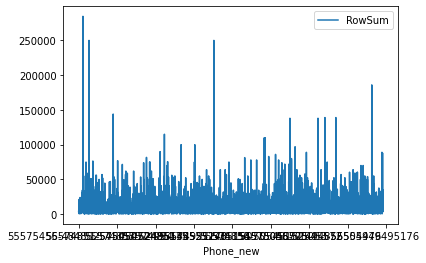

In [ ]:
df.plot(x = 'Phone_new', y = 'RowSum')

# СБОРКА ВИТРИНЫ ПО КЛИЕНТАМ ДЛЯ СЕГМЕНТАЦИИ

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from tabulate import tabulate
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

In [ ]:
#загрузка очищенных данных
df_clean = pd.read_excel('df_paid_10.10.xlsx')

In [ ]:
df = df_clean

In [ ]:
df.head()

,Order_ID,Phone_new,Source,PaymentType,Region,FullSum,Quant,Discount,RowSum,TN,TK
0,1303000522_TT,55575456-48485254505072,Онлайн-Резерв.,при получении,Центральный ф.о.,3919.0,1,0,3919,Мелкая бытовая техника,Приготовление пищи
1,1303000527_TT,55574952-52545355505473,Онлайн-Резерв.,предоплата онлайн,Центральный ф.о.,5440.0,1,0,2350,Мелкая бытовая техника,Приготовление пищи
2,1303000527_TT,55574952-52545355505473,Онлайн-Резерв.,предоплата онлайн,Центральный ф.о.,5440.0,1,0,3090,Мелкая бытовая техника,Приготовление пищи
3,1303000542_TT,55574951-505356545052725,Онлайн-Резерв.,предоплата онлайн,Центральный ф.о.,10487.0,1,1,10487,Крупная бытовая техника,Плиты
4,1303000545_TT,55575448-48485454505473,Онлайн-Резерв.,при получении,Центральный ф.о.,1050.0,1,1,800,Спорт и активный отдых,Фитнес


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3958 entries, 0 to 3957
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Order_ID     3958 non-null   object 
 1   Phone_new    3958 non-null   object 
 2   Source       3958 non-null   object 
 3   PaymentType  3958 non-null   object 
 4   Region       3958 non-null   object 
 5   FullSum      3958 non-null   float64
 6   Quant        3958 non-null   int64  
 7   Discount     3958 non-null   int64  
 8   RowSum       3958 non-null   int64  
 9   TN           3954 non-null   object 
 10  TK           3954 non-null   object 
dtypes: float64(1), int64(3), object(7)
memory usage: 340.3+ KB


In [ ]:
#группировки по столбцам
group_Source = df.groupby(['Phone_new', 'Source']).sum()
group_PaymentType = df.groupby(['Phone_new', 'PaymentType']).sum()
group_Region = df.groupby(['Phone_new', 'Region']).sum()
group_TN = df.groupby(['Phone_new', 'TN']).sum()
group_TK = df.groupby(['Phone_new', 'TK']).sum()

In [ ]:
group_Order = df.groupby(['Phone_new', 'Order_ID']).sum()['RowSum'].groupby('Phone_new').mean() #средний чек

In [ ]:
#группировки по среднему значению и к-ву
group_Phone_mean = df.groupby(['Phone_new']).mean()
group_Phone_count = df.groupby(['Phone_new']).count()


In [ ]:
#создание датафрейма для записи информации по клиентам
data_clients = pd.DataFrame()
data_clients['id'] = df.drop_duplicates(subset = 'Phone_new')['Phone_new']
data_clients = data_clients.reset_index(drop=True)

In [ ]:
data_clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3165 entries, 0 to 3164
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      3165 non-null   object
dtypes: object(1)
memory usage: 24.9+ KB


In [ ]:
pd.concat

<function pandas.core.reshape.concat.concat(objs: 'Iterable[NDFrame] | Mapping[Hashable, NDFrame]', axis=0, join='outer', ignore_index: 'bool' = False, keys=None, levels=None, names=None, verify_integrity: 'bool' = False, sort: 'bool' = False, copy: 'bool' = True) -> 'FrameOrSeriesUnion'>

In [ ]:
pd.merge

<function pandas.core.reshape.merge.merge(left: 'DataFrame | Series', right: 'DataFrame | Series', how: 'str' = 'inner', on: 'IndexLabel | None' = None, left_on: 'IndexLabel | None' = None, right_on: 'IndexLabel | None' = None, left_index: 'bool' = False, right_index: 'bool' = False, sort: 'bool' = False, suffixes: 'Suffixes' = ('_x', '_y'), copy: 'bool' = True, indicator: 'bool' = False, validate: 'str | None' = None) -> 'DataFrame'>

In [ ]:
from pandas.core.reshape.merge import merge

**Добавление столбцов для разделения категориальных признаков**

In [ ]:

#for i in df.TN.unique():
    #data_clients[i] = i
    #data_clients = data_clients.merge(group_TN['Quant'], left_on = ['id', i], right_on = ['Phone_new','TN'], how = 'left')
    #data_clients = data_clients.drop(columns = [i])
    #data_clients = data_clients.rename(columns = {'Quant': i})
    #data_clients = data_clients.fillna(0)

In [ ]:
for i in df.Source.unique():
    data_clients[i] = i
    data_clients = data_clients.merge(group_Source['Quant'], left_on = ['id', i], right_on = ['Phone_new', 'Source'], how = 'left')
    data_clients = data_clients.drop(columns = [i])
    data_clients = data_clients.rename(columns = {'Quant': i})
    data_clients = data_clients.fillna(0)

In [ ]:
for i in df.PaymentType.unique():
    data_clients[i] = i
    data_clients = data_clients.merge(group_PaymentType['Quant'], left_on = ['id', i], right_on = ['Phone_new', 'PaymentType'], how = 'left')
    data_clients = data_clients.drop(columns = [i])
    data_clients = data_clients.rename(columns = {'Quant': i})
    data_clients = data_clients.fillna(0)

In [ ]:
for i in df.Region.unique():
    data_clients[i] = i
    data_clients = data_clients.merge(group_Region['Quant'], left_on = ['id', i], right_on = ['Phone_new', 'Region'], how = 'left')
    data_clients = data_clients.drop(columns = [i])
    data_clients = data_clients.rename(columns = {'Quant': i})
    data_clients = data_clients.fillna(0)

In [ ]:
#кол-во чеков и к-во товаров в чеке
group_Phone_count = group_Phone_count.rename(columns = {'FullSum': 'К-во чеков'})
group_Phone_count = group_Phone_count.rename(columns = {'Quant': 'К-во товар.в чеке'})

In [ ]:
#добавление основных столбцов с суммами и к-вом товаров
data_clients = data_clients.merge(df.groupby(['Phone_new']).sum(), left_on = ['id'], right_on = ['Phone_new'], how = 'left')

In [ ]:
data_clients.head()

,id,Онлайн-Резерв.,Сайт,Колл-центр,Терминал,при получении,предоплата онлайн,Центральный ф.о.,Южный ф.о.,Сибирский ф.о.,Уральский ф.о.,Приволжский ф.о.,Северо-Западный ф.о.,Дальневосточный ф.о.,FullSum,Quant,Discount,RowSum
0,55575456-48485254505072,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3919.0,1,0,3919
1,55574952-52545355505473,2.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,10880.0,2,0,5440
2,55574951-505356545052725,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,10487.0,1,1,10487
3,55575448-48485454505473,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1050.0,1,1,800
4,55574952-565553534853705,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5999.0,1,0,5999


In [ ]:
data_clients = data_clients.drop(columns=['FullSum', 'RowSum'])
data_clients.rename(columns = {'Quant' : 'КОЛ-ВО ВЫКУПЛ.ТОВ.'}, inplace = True) 
data_clients.rename(columns = {'RowDiscount' : 'СУММА СКИДКИ'}, inplace = True) 

In [ ]:
#добавляем столбец с количеством чеков
data_clients = data_clients.merge(df.groupby(['Phone_new', 'Order_ID']).sum()['RowSum'].groupby('Phone_new').count(), left_on = ['id'], right_on = ['Phone_new'], how = 'left')

In [ ]:
data_clients = data_clients.rename(columns={'RowSum':'КОЛ-ВО ЧЕКОВ'})

In [ ]:
#среднее кол-во товаров в чеке
data_clients['СРЕД.КОЛ.ТОВ.вЧеке'] = data_clients['КОЛ-ВО ВЫКУПЛ.ТОВ.'] / data_clients['КОЛ-ВО ЧЕКОВ']

In [ ]:
#добавляем столбец со средним чеком
data_clients = data_clients.merge(df.groupby(['Phone_new', 'Order_ID']).sum()['RowSum'].groupby('Phone_new').mean(), left_on = ['id'], right_on = ['Phone_new'], how = 'left')
data_clients = data_clients.rename(columns={'RowSum':'СРЕДНИЙ ЧЕК'})

In [ ]:
data_clients = data_clients.rename(columns={'RowSum':'СРЕДНИЙ ЧЕК'})

In [ ]:
#checks = data_clients['К-во чеков'].sum().astype('int32')
#goods_value = data_clients['К-во товар.в чеке'].sum().astype('int32')
#total_sum = data_clients['RowSum'].sum().astype('int32')

#data_clients['Ценность клиента'] = None
#data_clients['Ценность клиента'] = [x/total_sum for x in data_clients['RowSum']]

In [ ]:
#перезаполняем столбцы TN долями вместо кол-ва
#data_clients['Аксессуары'] = data_clients['Аксессуары'] / data_clients['КОЛ-ВО ВЫКУПЛ.ТОВ.']
#data_clients['Крупная бытовая техника'] = data_clients['Крупная бытовая техника'] / data_clients['КОЛ-ВО ВЫКУПЛ.ТОВ.']
#data_clients['Цифровая Техника'] = data_clients['Цифровая Техника'] / data_clients['КОЛ-ВО ВЫКУПЛ.ТОВ.']
#data_clients['Мелкая бытовая техника'] = data_clients['Мелкая бытовая техника'] / data_clients['КОЛ-ВО ВЫКУПЛ.ТОВ.']
#data_clients['ТВ-Аудио'] = data_clients['ТВ-Аудио'] / data_clients['КОЛ-ВО ВЫКУПЛ.ТОВ.']
#data_clients['Мебель'] = data_clients['Мебель'] / data_clients['КОЛ-ВО ВЫКУПЛ.ТОВ.']
#data_clients['Детские товары'] = data_clients['Детские товары'] / data_clients['КОЛ-ВО ВЫКУПЛ.ТОВ.']
#data_clients['Спорт и активный отдых'] = data_clients['Спорт и активный отдых'] / data_clients['КОЛ-ВО ВЫКУПЛ.ТОВ.']
#data_clients['Сделай сам'] = data_clients['Сделай сам'] / data_clients['КОЛ-ВО ВЫКУПЛ.ТОВ.']
#data_clients['Климат'] = data_clients['Климат'] / data_clients['КОЛ-ВО ВЫКУПЛ.ТОВ.']
#data_clients['Игры, софт и развлечения'] = data_clients['Игры, софт и развлечения'] / data_clients['КОЛ-ВО ВЫКУПЛ.ТОВ.']
#data_clients['Товары для дома'] = data_clients['Товары для дома'] / data_clients['КОЛ-ВО ВЫКУПЛ.ТОВ.']
#data_clients['Автотовары'] = data_clients['Автотовары'] / data_clients['КОЛ-ВО ВЫКУПЛ.ТОВ.']
#data_clients['Элитная техника'] = data_clients['Элитная техника'] / data_clients['КОЛ-ВО ВЫКУПЛ.ТОВ.']

In [ ]:
#добавляем столбец со средним чеком
data_clients = data_clients.merge(df.groupby(['Phone_new', 'Order_ID']).sum()['RowSum'].groupby('Phone_new').mean(), left_on = ['id'], right_on = ['Phone_new'], how = 'left')
data_clients = data_clients.rename(columns={'RowSum':'СРЕДНИЙ ЧЕК'})

In [ ]:
data_clients = data_clients.rename(columns={'RowSum':'СРЕДНИЙ ЧЕК'})

In [ ]:
#витрина по клиентам
data_clients.head()

,id,Онлайн-Резерв.,Сайт,Колл-центр,Терминал,при получении,предоплата онлайн,Центральный ф.о.,Южный ф.о.,Сибирский ф.о.,Уральский ф.о.,Приволжский ф.о.,Северо-Западный ф.о.,Дальневосточный ф.о.,КОЛ-ВО ВЫКУПЛ.ТОВ.,Discount,КОЛ-ВО ЧЕКОВ,СРЕД.КОЛ.ТОВ.вЧеке,СРЕДНИЙ ЧЕК,СРЕДНИЙ ЧЕК
0,55575456-48485254505072,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1,1.0,3919.0,3919.0
1,55574952-52545355505473,2.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0,1,2.0,5440.0,5440.0
2,55574951-505356545052725,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,1.0,10487.0,10487.0
3,55575448-48485454505473,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,1.0,800.0,800.0
4,55574952-565553534853705,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1,1.0,5999.0,5999.0


In [ ]:
#сохранение датафрейма для дальнейшего исследования на корреляцию
data_clients.to_csv('/content/drive/MyDrive/Attestation/data_clients_19.10.csv')

In [ ]:
#чтение
df = pd.read_csv('/content/drive/MyDrive/Attestation/data_clients_19.10.csv')
df.set_index('id', inplace = True)
df.drop(['Unnamed: 0'], axis = 1, inplace = True)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3165 entries, 55575456-48485254505072 to 55574955-55494953525471
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Онлайн-Резерв.        3165 non-null   float64
 1   Сайт                  3165 non-null   float64
 2   Колл-центр            3165 non-null   float64
 3   Терминал              3165 non-null   float64
 4   при получении         3165 non-null   float64
 5   предоплата онлайн     3165 non-null   float64
 6   Центральный ф.о.      3165 non-null   float64
 7   Южный ф.о.            3165 non-null   float64
 8   Сибирский ф.о.        3165 non-null   float64
 9   Уральский ф.о.        3165 non-null   float64
 10  Приволжский ф.о.      3165 non-null   float64
 11  Северо-Западный ф.о.  3165 non-null   float64
 12  Дальневосточный ф.о.  3165 non-null   float64
 13  КОЛ-ВО ВЫКУПЛ.ТОВ.    3165 non-null   int64  
 14  Discount              3165 non-null 

# Корреляция

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.context('seaborn');

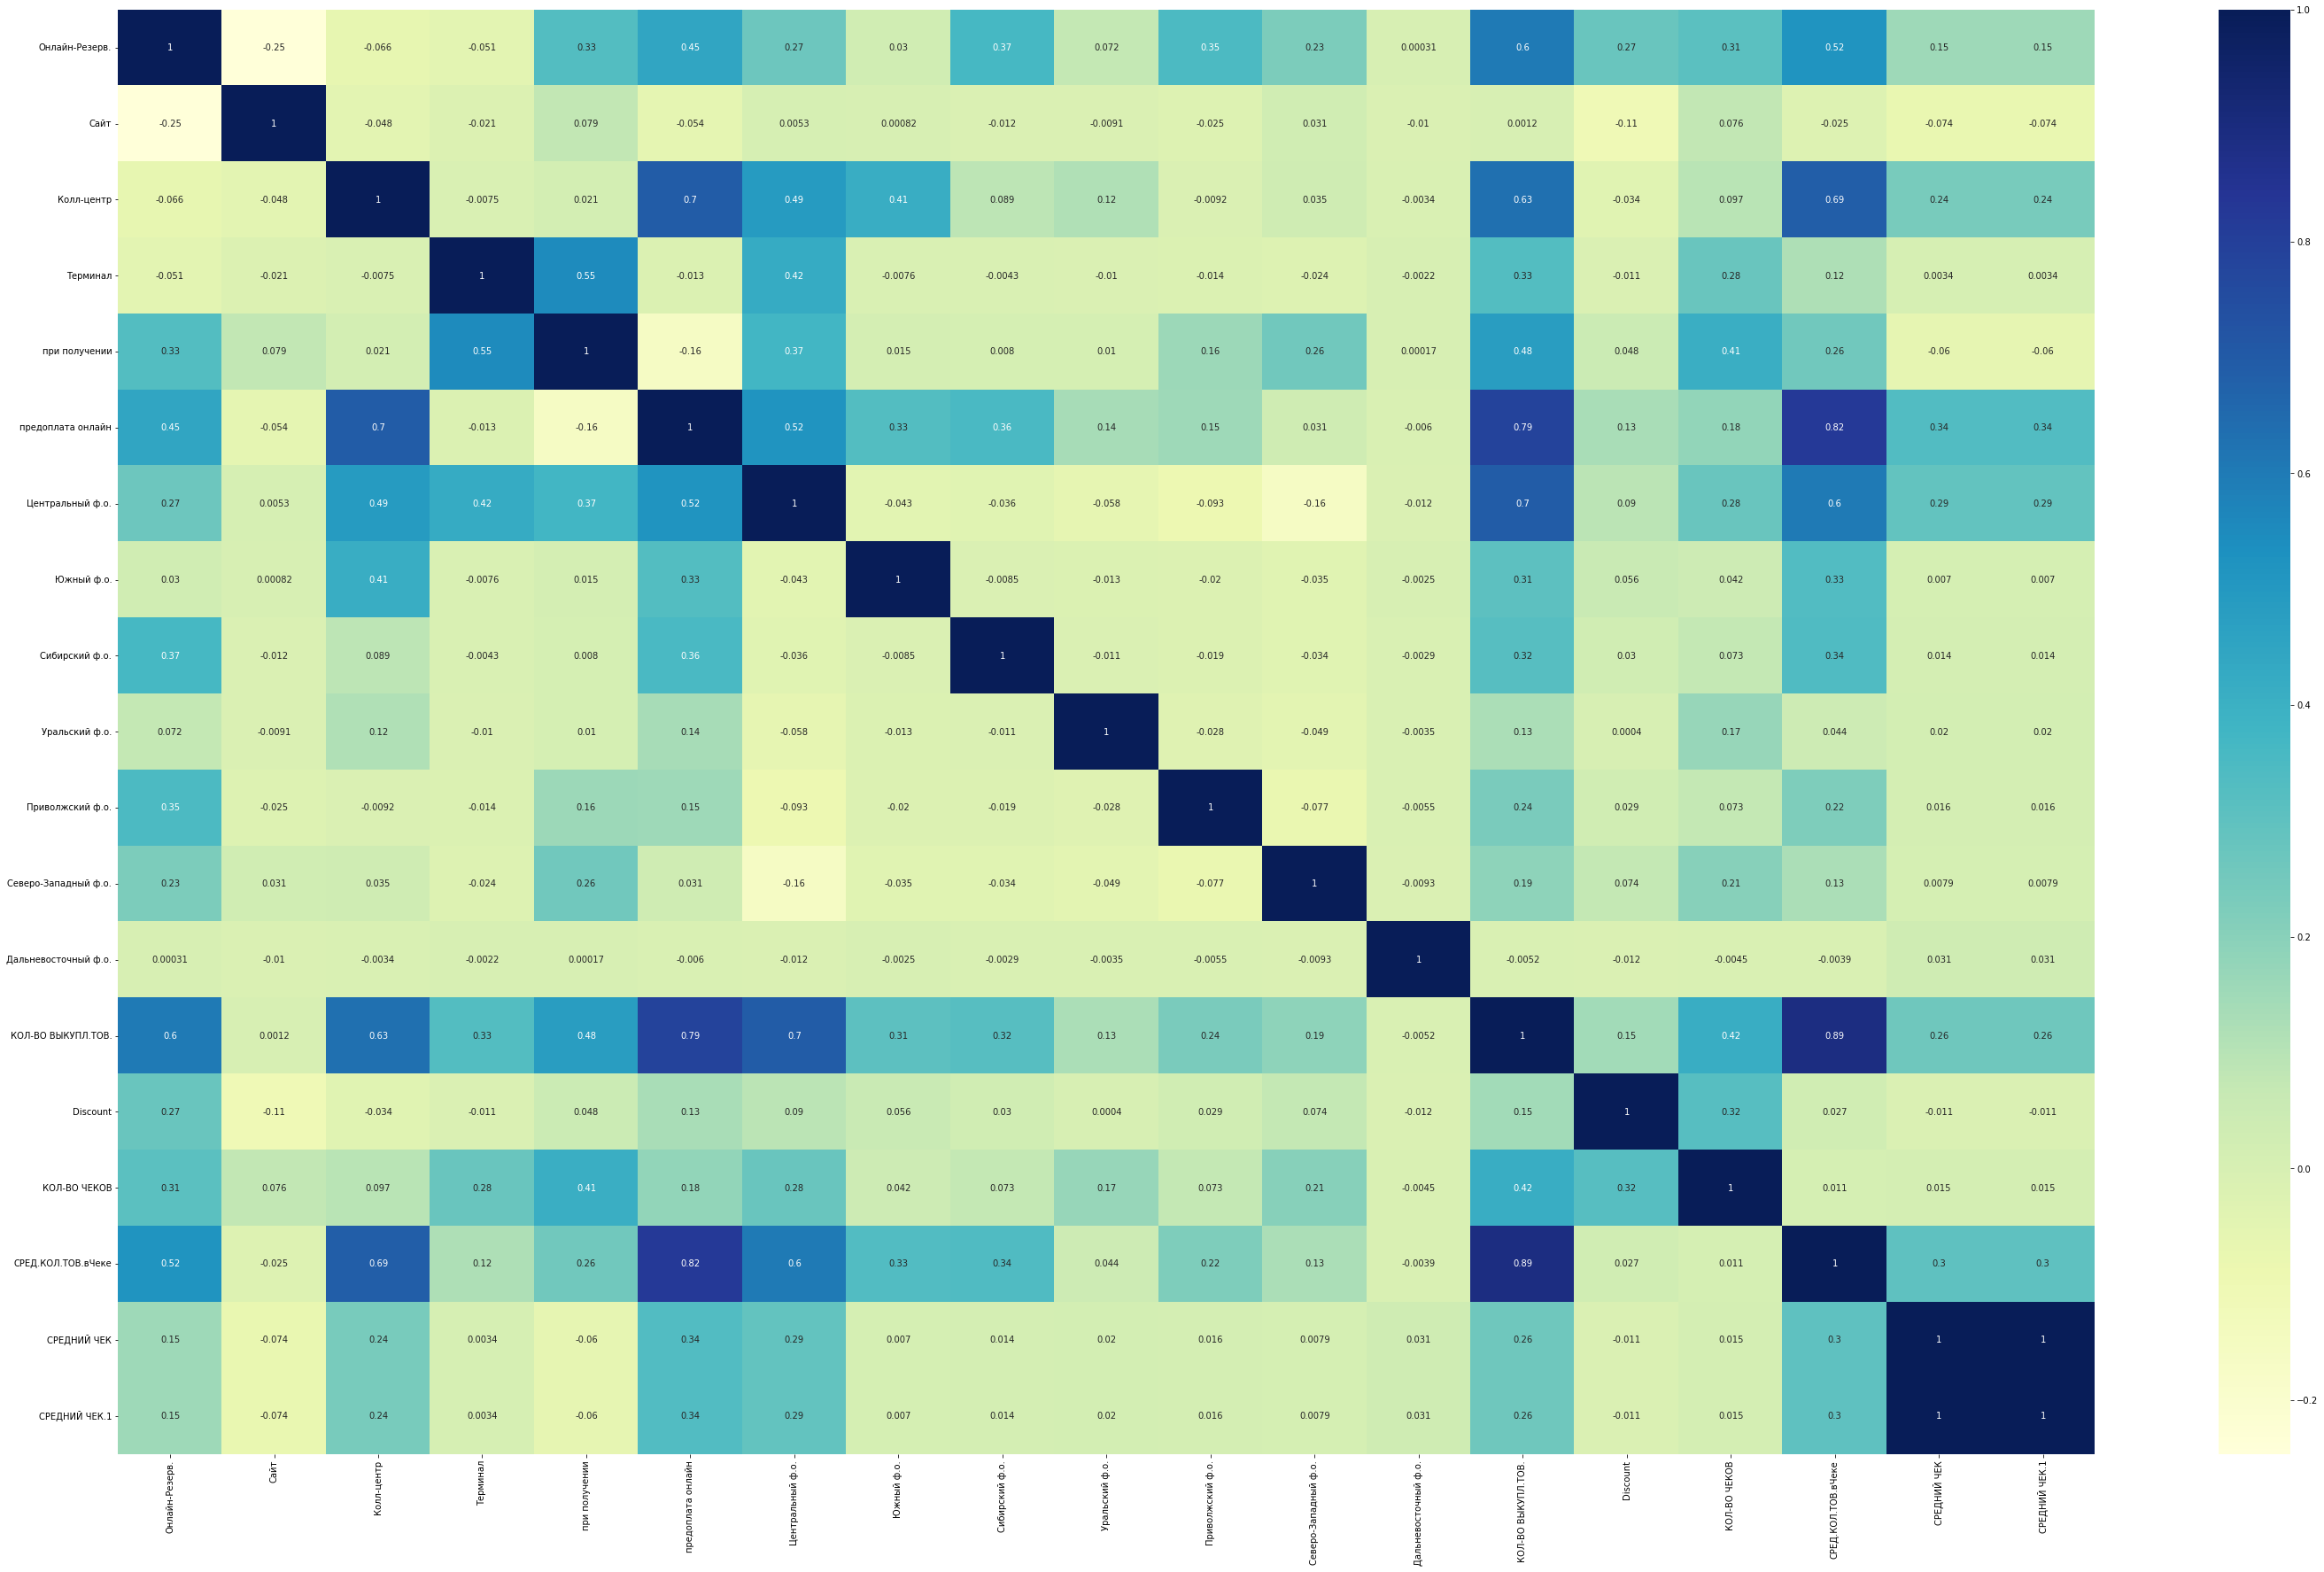

In [ ]:
fig = plt.figure(figsize = (50, 30))
sns.heatmap(df.corr(), annot=True, cmap = 'YlGnBu');

In [ ]:
corr = df.corr(method='spearman')
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

<ipython-input-150-de0877c3568b>:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='coolwarm').set_precision(2)


,Онлайн-Резерв.,Сайт,Колл-центр,Терминал,при получении,предоплата онлайн,Центральный ф.о.,Южный ф.о.,Сибирский ф.о.,Уральский ф.о.,Приволжский ф.о.,Северо-Западный ф.о.,Дальневосточный ф.о.,КОЛ-ВО ВЫКУПЛ.ТОВ.,Discount,КОЛ-ВО ЧЕКОВ,СРЕД.КОЛ.ТОВ.вЧеке,СРЕДНИЙ ЧЕК,СРЕДНИЙ ЧЕК.1
Онлайн-Резерв.,1.00,-0.55,-0.46,-0.25,-0.04,0.31,0.01,0.05,0.04,0.04,0.07,0.03,0.01,0.48,0.33,0.26,0.41,0.09,0.09
Сайт,-0.55,1.00,-0.14,-0.07,0.12,-0.15,-0.02,0.01,-0.02,-0.00,-0.03,0.05,-0.01,-0.04,-0.16,0.06,-0.11,-0.09,-0.09
Колл-центр,-0.46,-0.14,1.00,-0.06,0.14,-0.12,0.09,-0.02,-0.02,-0.03,-0.03,-0.03,-0.01,0.06,-0.17,0.05,0.05,0.03,0.03
Терминал,-0.25,-0.07,-0.06,1.00,0.11,-0.09,0.15,-0.03,-0.03,-0.03,-0.05,-0.06,-0.00,0.02,-0.05,0.06,0.02,0.00,0.00
при получении,-0.04,0.12,0.14,0.11,1.00,-0.84,0.01,-0.01,-0.00,0.02,0.02,0.08,0.01,0.31,-0.09,0.18,0.27,-0.18,-0.18
предоплата онлайн,0.31,-0.15,-0.12,-0.09,-0.84,1.00,0.11,0.03,0.00,-0.02,0.00,-0.07,-0.01,0.20,0.20,0.16,0.14,0.26,0.26
Центральный ф.о.,0.01,-0.02,0.09,0.15,0.01,0.11,1.00,-0.22,-0.24,-0.21,-0.36,-0.53,-0.03,0.22,0.02,0.14,0.19,0.07,0.07
Южный ф.о.,0.05,0.01,-0.02,-0.03,-0.01,0.03,-0.22,1.00,-0.04,-0.04,-0.07,-0.11,-0.01,0.03,0.05,0.03,0.03,-0.01,-0.01
Сибирский ф.о.,0.04,-0.02,-0.02,-0.03,-0.00,0.00,-0.24,-0.04,1.00,-0.04,-0.08,-0.12,-0.01,0.00,-0.00,-0.02,0.02,0.01,0.01
Уральский ф.о.,0.04,-0.00,-0.03,-0.03,0.02,-0.02,-0.21,-0.04,-0.04,1.00,-0.07,-0.10,-0.01,0.01,0.00,0.01,0.00,0.01,0.01


In [ ]:
corr = df.corr(method='spearman')
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

<ipython-input-151-de0877c3568b>:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='coolwarm').set_precision(2)


,Онлайн-Резерв.,Сайт,Колл-центр,Терминал,при получении,предоплата онлайн,Центральный ф.о.,Южный ф.о.,Сибирский ф.о.,Уральский ф.о.,Приволжский ф.о.,Северо-Западный ф.о.,Дальневосточный ф.о.,КОЛ-ВО ВЫКУПЛ.ТОВ.,Discount,КОЛ-ВО ЧЕКОВ,СРЕД.КОЛ.ТОВ.вЧеке,СРЕДНИЙ ЧЕК,СРЕДНИЙ ЧЕК.1
Онлайн-Резерв.,1.00,-0.55,-0.46,-0.25,-0.04,0.31,0.01,0.05,0.04,0.04,0.07,0.03,0.01,0.48,0.33,0.26,0.41,0.09,0.09
Сайт,-0.55,1.00,-0.14,-0.07,0.12,-0.15,-0.02,0.01,-0.02,-0.00,-0.03,0.05,-0.01,-0.04,-0.16,0.06,-0.11,-0.09,-0.09
Колл-центр,-0.46,-0.14,1.00,-0.06,0.14,-0.12,0.09,-0.02,-0.02,-0.03,-0.03,-0.03,-0.01,0.06,-0.17,0.05,0.05,0.03,0.03
Терминал,-0.25,-0.07,-0.06,1.00,0.11,-0.09,0.15,-0.03,-0.03,-0.03,-0.05,-0.06,-0.00,0.02,-0.05,0.06,0.02,0.00,0.00
при получении,-0.04,0.12,0.14,0.11,1.00,-0.84,0.01,-0.01,-0.00,0.02,0.02,0.08,0.01,0.31,-0.09,0.18,0.27,-0.18,-0.18
предоплата онлайн,0.31,-0.15,-0.12,-0.09,-0.84,1.00,0.11,0.03,0.00,-0.02,0.00,-0.07,-0.01,0.20,0.20,0.16,0.14,0.26,0.26
Центральный ф.о.,0.01,-0.02,0.09,0.15,0.01,0.11,1.00,-0.22,-0.24,-0.21,-0.36,-0.53,-0.03,0.22,0.02,0.14,0.19,0.07,0.07
Южный ф.о.,0.05,0.01,-0.02,-0.03,-0.01,0.03,-0.22,1.00,-0.04,-0.04,-0.07,-0.11,-0.01,0.03,0.05,0.03,0.03,-0.01,-0.01
Сибирский ф.о.,0.04,-0.02,-0.02,-0.03,-0.00,0.00,-0.24,-0.04,1.00,-0.04,-0.08,-0.12,-0.01,0.00,-0.00,-0.02,0.02,0.01,0.01
Уральский ф.о.,0.04,-0.00,-0.03,-0.03,0.02,-0.02,-0.21,-0.04,-0.04,1.00,-0.07,-0.10,-0.01,0.01,0.00,0.01,0.00,0.01,0.01


In [ ]:
df.to_csv('/content/drive/MyDrive/Attestation/data_for_klasters_19.10.csv') #витрина по клиентам после удаления коррелированных столбцов


Загрузка готовой витрины по клиентам для нормализации и стандартизации.

Без коррелированных столбцов.

In [ ]:
#подключение к гугл_диску
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from tabulate import tabulate
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

In [ ]:
#чтение
df = pd.read_csv('/content/drive/MyDrive/Attestation/data_for_klasters_19.10.csv')
df.set_index('id', inplace = True)
#df.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [ ]:
df.head()

,Онлайн-Резерв.,Сайт,Колл-центр,Терминал,при получении,предоплата онлайн,Центральный ф.о.,Южный ф.о.,Сибирский ф.о.,Уральский ф.о.,Приволжский ф.о.,Северо-Западный ф.о.,Дальневосточный ф.о.,КОЛ-ВО ВЫКУПЛ.ТОВ.,Discount,КОЛ-ВО ЧЕКОВ,СРЕД.КОЛ.ТОВ.вЧеке,СРЕДНИЙ ЧЕК,СРЕДНИЙ ЧЕК.1
id,,,,,,,,,,,,,,,,,,,
55575456-48485254505072,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1,1.0,3919.0,3919.0
55574952-52545355505473,2.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0,1,2.0,5440.0,5440.0
55574951-505356545052725,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,1.0,10487.0,10487.0
55575448-48485454505473,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,1.0,800.0,800.0
55574952-565553534853705,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1,1.0,5999.0,5999.0


# Remove outliers (удаление выбросов)

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
%%time
outliers = IsolationForest(n_estimators=20, random_state=0).fit_predict(df.values)  # fit 3 trees  
outliers = (outliers+1)//2

print('% of outliers with Isolation forest:', 1 - (np.sum(outliers) / df.shape[0]))

% of outliers with Isolation forest: 0.04676145339652449
CPU times: user 84.1 ms, sys: 2.97 ms, total: 87.1 ms
Wall time: 96.1 ms


In [ ]:
df = df.loc[np.array(df.index)[outliers == 1]]

In [ ]:
df.shape

(3017, 19)

# Нормализация

In [ ]:
from sklearn import preprocessing

In [ ]:
scaler = preprocessing.StandardScaler()
# normalize
X = scaler.fit_transform(df)

In [ ]:
#выгрузка стандартизированных, нормализированных данных по клиентам (без коррелированных столбцов)
df.to_csv('/content/drive/MyDrive/Attestation/data_for_klasters_norm.csv')

# Кластеризация K-means

In [ ]:
#загрузка стандартизированных, нормализированных данных по клиентам
df = pd.read_csv('/content/drive/MyDrive/Attestation/data_for_klasters_norm.csv')
df.set_index('id', inplace = True)

In [ ]:
from sklearn.cluster import KMeans #DBSCAN, AgglomerativeClustering, MeanShift, MiniBatchKMeans, OPTICS
from scipy.spatial.distance import cdist

### Метод локтя

In [ ]:
%%time
# k means determine k
distortions = []
K = range(1,16)
for k in K:
    kmeanModel = KMeans(n_clusters=k, max_iter=500, n_init=20, random_state=15).fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    
    print('{} / {}'.format(k,K[-1]))

1 / 15
2 / 15
3 / 15
4 / 15
5 / 15
6 / 15
7 / 15
8 / 15
9 / 15
10 / 15
11 / 15
12 / 15
13 / 15
14 / 15
15 / 15
CPU times: user 18.4 s, sys: 9.01 s, total: 27.4 s
Wall time: 17.3 s


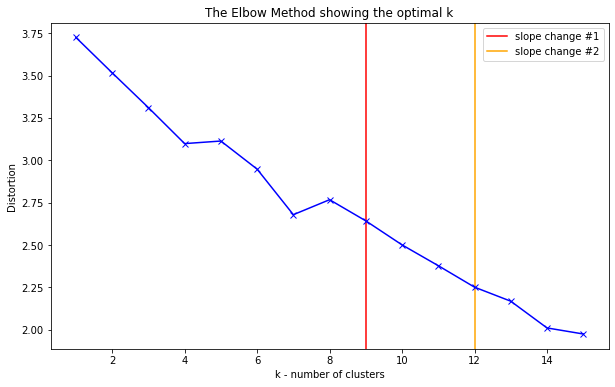

In [ ]:
#определение оптимального к-ва кластеров методом локтя
plt.figure(figsize=(10, 6))
plt.axvline(9, 0, 1, label='slope change #1', color='red')
plt.axvline(12, 0, 1, label='slope change #2', color='orange')
plt.plot(K, distortions, 'bx-')
plt.xlabel('k - number of clusters')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.legend(); plt.show()

Перегибы: 4,7,14

самые оптимальные: 4 и 7 кластеров

### K-means для 9 кластеров

In [ ]:
from sklearn.decomposition import PCA, TruncatedSVD

In [ ]:
Y_pca = PCA(n_components=3).fit_transform(X);
Y_svd = TruncatedSVD(n_components=3).fit_transform(X);

In [ ]:
K = 9
#kmeanModel = KMeans(n_clusters=K, max_iter=500, n_init=20, random_state=7).fit(X)
kmeanModel = KMeans(n_clusters=K).fit(X)

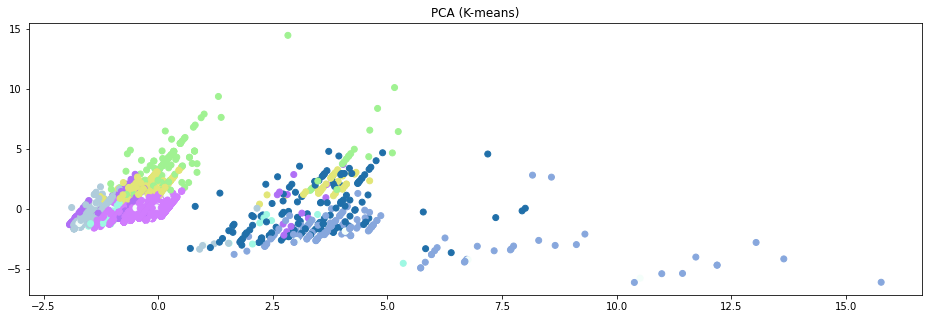

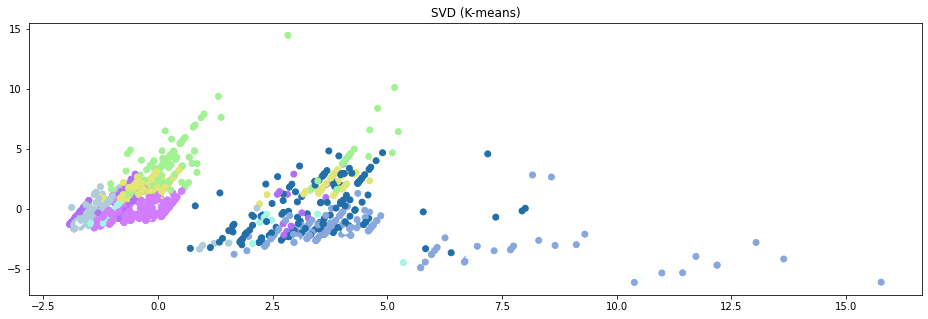

In [ ]:
np.random.seed(21)
colors = np.sqrt(np.random.randint(0,255, size=(K, 3))/255)
c_arr = np.array(list(map(lambda x: colors[x], list(kmeanModel.labels_))))

plt.figure(figsize=(16,5));
plt.title('PCA (K-means)')
plt.scatter(Y_pca[:, 0], Y_pca[:, 1], c=c_arr);

plt.figure(figsize=(16,5)); plt.title('SVD (K-means)')
plt.scatter(Y_svd[:, 0], Y_svd[:, 1], c=c_arr);

In [ ]:
# координаты центра копирования
centroids = kmeanModel.cluster_centers_ 

# метка кластера для каждой точки данных
labels = kmeanModel.labels_

df['Labels'] = kmeanModel.labels_

df_1 = df[(df['Labels'] == 0)]
df_2 = df[(df['Labels'] == 1)]
df_3 = df[(df['Labels'] == 2)]
df_4 = df[(df['Labels'] == 3)]
df_5 = df[(df['Labels'] == 4)]
df_6 = df[(df['Labels'] == 5)]
df_7 = df[(df['Labels'] == 6)]
df_8 = df[(df['Labels'] == 7)]
df_9 = df[(df['Labels'] == 8)]

print('Segment 1: ', len(df_1))
print('Segment 2: ', len(df_2))
print('Segment 3: ', len(df_3))
print('Segment 4: ', len(df_4))
print('Segment 5: ', len(df_5))
print('Segment 6: ', len(df_6))
print('Segment 7: ', len(df_7))
print('Segment 8: ', len(df_8))
print('Segment 9: ', len(df_9))
print('df: ', len(df))

Segment 1:  462
Segment 2:  148
Segment 3:  399
Segment 4:  92
Segment 5:  157
Segment 6:  1352
Segment 7:  113
Segment 8:  154
Segment 9:  140
df:  3017


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
%matplotlib inline

In [ ]:
print(f'Silhouette Score(n=9): {silhouette_score(X, labels)}')
print(f'Davies-Boulding Index (n=9): {davies_bouldin_score(X, labels)}')
print(f'Calinski-Harabasz Index (n=9): {calinski_harabasz_score(X, labels)}')

Silhouette Score(n=9): 0.28016813102949967
Davies-Boulding Index (n=9): 1.3443538235566728
Calinski-Harabasz Index (n=9): 341.22485316711277


### K-means для 11 кластеров

In [ ]:
K = 11
#kmeanModel = KMeans(n_clusters=K, max_iter=500, n_init=20, random_state=7).fit(X)
kmeanModel = KMeans(n_clusters=K).fit(X)

# coordinates of cluster center
centroids = kmeanModel.cluster_centers_ 

# cluster label for each data point
labels = kmeanModel.labels_

df['Labels'] = kmeanModel.labels_

df_1 = df[(df['Labels'] == 0)]
df_2 = df[(df['Labels'] == 1)]
df_3 = df[(df['Labels'] == 2)]
df_4 = df[(df['Labels'] == 3)]
df_5 = df[(df['Labels'] == 4)]
df_6 = df[(df['Labels'] == 5)]
df_7 = df[(df['Labels'] == 6)]
df_8 = df[(df['Labels'] == 7)]
df_9 = df[(df['Labels'] == 8)]
df_10 = df[(df['Labels'] == 9)]
df_11 = df[(df['Labels'] == 10)]

print('Segment 1: ', len(df_1))
print('Segment 2: ', len(df_2))
print('Segment 3: ', len(df_3))
print('Segment 4: ', len(df_4))
print('Segment 5: ', len(df_5))
print('Segment 6: ', len(df_6))
print('Segment 7: ', len(df_7))
print('Segment 8: ', len(df_8))
print('Segment 9: ', len(df_9))
print('Segment 10: ', len(df_10))
print('Segment 11: ', len(df_11))
print('df: ', len(df))

Segment 1:  92
Segment 2:  411
Segment 3:  688
Segment 4:  304
Segment 5:  268
Segment 6:  142
Segment 7:  445
Segment 8:  2
Segment 9:  116
Segment 10:  123
Segment 11:  426
df:  3017


In [ ]:
df.groupby('Labels').sum().to_excel('11_klasters.xlsx')

### K-means для 12 кластеров

In [ ]:
K = 12
#kmeanModel = KMeans(n_clusters=K, max_iter=500, n_init=20, random_state=7).fit(X)
kmeanModel = KMeans(n_clusters=K).fit(X)
# coordinates of cluster center
centroids = kmeanModel.cluster_centers_ 
# cluster label for each data point
labels = kmeanModel.labels_
df['Labels'] = kmeanModel.labels_
df_1 = df[(df['Labels'] == 0)]
df_2 = df[(df['Labels'] == 1)]
df_3 = df[(df['Labels'] == 2)]
df_4 = df[(df['Labels'] == 3)]
df_5 = df[(df['Labels'] == 4)]
df_6 = df[(df['Labels'] == 5)]
df_7 = df[(df['Labels'] == 6)]
df_8 = df[(df['Labels'] == 7)]
df_9 = df[(df['Labels'] == 8)]
df_10 = df[(df['Labels'] == 9)]
df_11 = df[(df['Labels'] == 10)]
df_12 = df[(df['Labels'] == 11)]

print('Segment 1: ', len(df_1))
print('Segment 2: ', len(df_2))
print('Segment 3: ', len(df_3))
print('Segment 4: ', len(df_4))
print('Segment 5: ', len(df_5))
print('Segment 6: ', len(df_6))
print('Segment 7: ', len(df_7))
print('Segment 8: ', len(df_8))
print('Segment 9: ', len(df_9))
print('Segment 10: ', len(df_10))
print('Segment 11: ', len(df_11))
print('Segment 12: ', len(df_12))
print('df: ', len(df))

Segment 1:  116
Segment 2:  427
Segment 3:  298
Segment 4:  389
Segment 5:  291
Segment 6:  151
Segment 7:  897
Segment 8:  2
Segment 9:  92
Segment 10:  77
Segment 11:  154
Segment 12:  123
df:  3017


In [ ]:
#сводная таблица по всем клиентам с номерами кластеров в соответствии с сегментацией
df.to_excel('/content/drive/MyDrive/Attestation/labels_for_12_klasters.xlsx')

In [ ]:
#сводная таблица данных по всем кластерам
df.groupby('Labels').sum().to_excel('12_klasters.xlsx')

In [ ]:
df.head()

,Онлайн-Резерв.,Сайт,Колл-центр,Терминал,при получении,предоплата онлайн,Центральный ф.о.,Южный ф.о.,Сибирский ф.о.,Уральский ф.о.,Приволжский ф.о.,Северо-Западный ф.о.,Дальневосточный ф.о.,КОЛ-ВО ВЫКУПЛ.ТОВ.,Discount,КОЛ-ВО ЧЕКОВ,СРЕД.КОЛ.ТОВ.вЧеке,СРЕДНИЙ ЧЕК,СРЕДНИЙ ЧЕК.1,Labels
id,,,,,,,,,,,,,,,,,,,,
55575456-48485254505072,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1,1.0,3919.0,3919.0,6
55574952-52545355505473,2.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0,1,2.0,5440.0,5440.0,2
55574951-505356545052725,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,1.0,10487.0,10487.0,6
55575448-48485454505473,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,1.0,800.0,800.0,6
55574952-565553534853705,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1,1.0,5999.0,5999.0,6


In [ ]:
df.to_excel('12_klasters.xlsx')

### K-means для 13 кластеров

In [ ]:
K = 13
kmeanModel = KMeans(n_clusters=K, max_iter=500, n_init=20, random_state=7).fit(X)
kmeanModel = KMeans(n_clusters=K).fit(X)

# coordinates of cluster center
centroids = kmeanModel.cluster_centers_ 

# cluster label for each data point
labels = kmeanModel.labels_

df['Labels'] = kmeanModel.labels_

df_1 = df[(df['Labels'] == 0)]
df_2 = df[(df['Labels'] == 1)]
df_3 = df[(df['Labels'] == 2)]
df_4 = df[(df['Labels'] == 3)]
df_5 = df[(df['Labels'] == 4)]
df_6 = df[(df['Labels'] == 5)]
df_7 = df[(df['Labels'] == 6)]
df_8 = df[(df['Labels'] == 7)]
df_9 = df[(df['Labels'] == 8)]
df_10 = df[(df['Labels'] == 9)]
df_11 = df[(df['Labels'] == 10)]
df_12 = df[(df['Labels'] == 11)]
df_13 = df[(df['Labels'] == 12)]

print('Segment 1: ', len(df_1))
print('Segment 2: ', len(df_2))
print('Segment 3: ', len(df_3))
print('Segment 4: ', len(df_4))
print('Segment 5: ', len(df_5))
print('Segment 6: ', len(df_6))
print('Segment 7: ', len(df_7))
print('Segment 8: ', len(df_8))
print('Segment 9: ', len(df_9))
print('Segment 10: ', len(df_10))
print('Segment 11: ', len(df_11))
print('Segment 12: ', len(df_12))
print('Segment 13: ', len(df_13))
print('df: ', len(df))

Segment 1:  114
Segment 2:  592
Segment 3:  384
Segment 4:  248
Segment 5:  288
Segment 6:  2
Segment 7:  143
Segment 8:  115
Segment 9:  92
Segment 10:  381
Segment 11:  154
Segment 12:  381
Segment 13:  123
df:  3017


In [ ]:
df.groupby('Labels').sum().to_excel('13_klasters.xlsx')

# Кластеризация Expectation-Maximization Algorithm(EM-кластеризация)


In [ ]:
from sklearn.mixture import GaussianMixture

### EM для 9 кластеров

In [ ]:
from sklearn import preprocessing
import pandas as pd

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Attestation/data_for_klasters_norm.csv', index_col=False)
scaler = preprocessing.StandardScaler()
# normalize
X = scaler.fit_transform(df.iloc[:,1:])

In [ ]:
import scipy

scipy.stats.normaltest(X)

NormaltestResult(statistic=array([ 356.12794986, 1138.52500288, 2161.042677  , 3687.20376863,
        457.42526675, 1060.96251126,  397.81125117, 3193.91290181,
       2854.11323886, 3735.35323441, 2331.77828968, 1275.45254984,
       8715.22353906, 2065.36814678, 1066.81368458, 2461.05328654,
       2812.26585826, 2529.24190129, 2529.24190129]), pvalue=array([4.65369871e-078, 5.92157003e-248, 0.00000000e+000, 0.00000000e+000,
       4.69207973e-100, 4.12019648e-231, 4.13413248e-087, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 1.09395092e-277,
       0.00000000e+000, 0.00000000e+000, 2.20979397e-232, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000]))

In [ ]:
Y_pca = PCA(n_components=3).fit_transform(X);
Y_svd = TruncatedSVD(n_components=3).fit_transform(X);

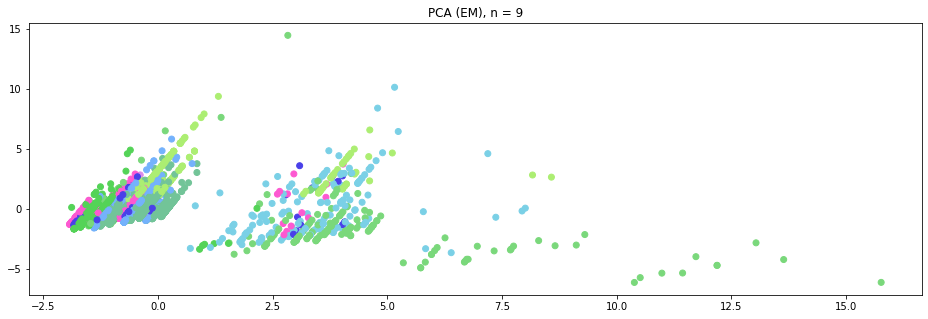

In [ ]:
n = 9
gm = GaussianMixture(n_components=n)
labels = gm.fit_predict(X)
df_labels = pd.DataFrame()
df_labels['Labels'] = labels

colors = np.sqrt(np.random.randint(0,255, size=(len(set(labels)), 3))/255)
c_arr = np.array(list(map(lambda x: colors[x], list(labels))))

plt.figure(figsize=(16,5)); plt.title('PCA (EM), n = 9')
plt.scatter(Y_pca[:, 0], Y_pca[:, 1], c=c_arr);

In [ ]:
df = df_labels

In [ ]:
df_labels.shape

(3017, 1)

In [ ]:
df_1 = df[(df['Labels'] == 0)]
df_2 = df[(df['Labels'] == 1)]
df_3 = df[(df['Labels'] == 2)]
df_4 = df[(df['Labels'] == 3)]
df_5 = df[(df['Labels'] == 4)]
df_6 = df[(df['Labels'] == 5)]
df_7 = df[(df['Labels'] == 6)]
df_8 = df[(df['Labels'] == 7)]
df_9 = df[(df['Labels'] == 8)]

data_sel9={0: df_1, 1: df_2, 2: df_3, 3: df_4, 4: df_5, 5: df_6, 6: df_7, 7: df_8, 8: df_9}

In [ ]:
for i in data_sel9.values():
  print(len(i))

1134
404
408
2
200
153
439
154
123


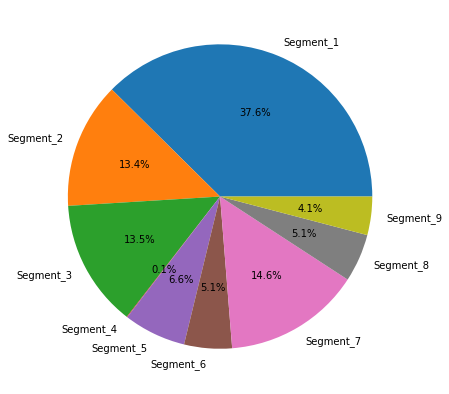

In [ ]:
fig = plt.figure(figsize =(10, 7))
data = [len(i) for i in data_sel9.values()]
labels = [('Segment_' + str(i)) for i in range(1, 10)]
plt.pie(data, labels=labels, autopct='%1.1f%%')

plt.show()

In [ ]:
df['Labels'] = df_labels['Labels']

In [ ]:
#сводная таблица по всем клиентам с номерами кластеров в соответствии с сегментацией
df.to_excel('labels_for_9_klasters.xlsx')

In [ ]:
df1 = pd.read_excel('/content/labels_for_9_klasters.xlsx', index_col=0) # таблица с кластерами

In [ ]:
df_ind = df1

EM для 12 кластеров

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Attestation/data_for_klasters_norm.csv', index_col=False)
scaler = preprocessing.StandardScaler()
# normalize
X = scaler.fit_transform(df.iloc[:,1:])

In [ ]:
import scipy

scipy.stats.normaltest(X)

NormaltestResult(statistic=array([ 356.12794986, 1138.52500288, 2161.042677  , 3687.20376863,
        457.42526675, 1060.96251126,  397.81125117, 3193.91290181,
       2854.11323886, 3735.35323441, 2331.77828968, 1275.45254984,
       8715.22353906, 2065.36814678, 1066.81368458, 2461.05328654,
       2812.26585826, 2529.24190129, 2529.24190129]), pvalue=array([4.65369871e-078, 5.92157003e-248, 0.00000000e+000, 0.00000000e+000,
       4.69207973e-100, 4.12019648e-231, 4.13413248e-087, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 1.09395092e-277,
       0.00000000e+000, 0.00000000e+000, 2.20979397e-232, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000]))

In [ ]:
Y_pca = PCA(n_components=3).fit_transform(X);
Y_svd = TruncatedSVD(n_components=3).fit_transform(X);

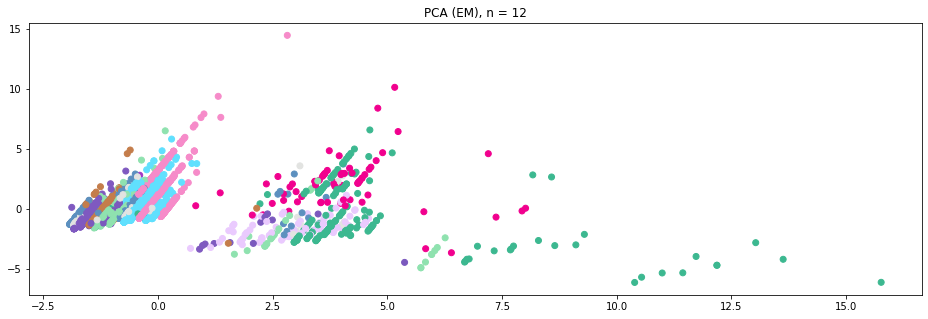

In [ ]:
n = 12
gm = GaussianMixture(n_components=n)
labels = gm.fit_predict(X)
df_labels = pd.DataFrame()
df_labels['Labels'] = labels

colors = np.sqrt(np.random.randint(0,255, size=(len(set(labels)), 3))/255)
c_arr = np.array(list(map(lambda x: colors[x], list(labels))))

plt.figure(figsize=(16,5)); plt.title('PCA (EM), n = 12')
plt.scatter(Y_pca[:, 0], Y_pca[:, 1], c=c_arr);

In [ ]:
df = df_labels

In [ ]:
df_labels.shape

(3017, 1)

In [ ]:
df_1 = df[(df['Labels'] == 0)]
df_2 = df[(df['Labels'] == 1)]
df_3 = df[(df['Labels'] == 2)]
df_4 = df[(df['Labels'] == 3)]
df_5 = df[(df['Labels'] == 4)]
df_6 = df[(df['Labels'] == 5)]
df_7 = df[(df['Labels'] == 6)]
df_8 = df[(df['Labels'] == 7)]
df_9 = df[(df['Labels'] == 8)]
df_10 = df[(df['Labels'] == 9)]
df_11 = df[(df['Labels'] == 10)]
df_12 = df[(df['Labels'] == 11)]

data_sel12={0: df_1, 1: df_2, 2: df_3, 3: df_4, 4: df_5, 5: df_6, 6: df_7, 7: df_8, 8: df_9, 9: df_10, 10: df_11, 11: df_12}

In [ ]:
for i in data_sel12.values():
  print(len(i))

176
915
2
701
123
92
66
183
154
293
84
228


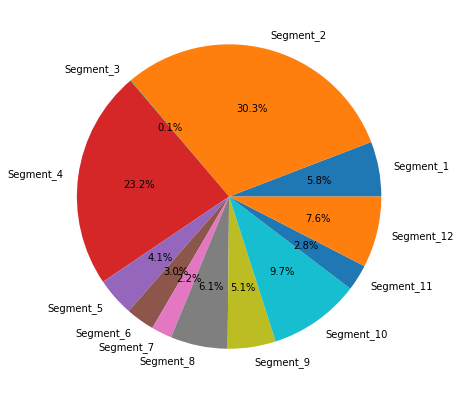

In [ ]:
fig = plt.figure(figsize =(10, 7))
data = [len(i) for i in data_sel12.values()]
labels = [('Segment_' + str(i)) for i in range(1, 13)]
plt.pie(data, labels=labels, autopct='%1.1f%%')

plt.show()

In [ ]:
df['Labels'] = df_labels['Labels']

In [ ]:
#сводная таблица по всем клиентам с номерами кластеров в соответствии с сегментацией
df.to_excel('labels_for_12_klasters.xlsx')

In [ ]:
df1 = pd.read_excel('/content/labels_for_12_klasters.xlsx', index_col=0) # таблица с кластерами

In [ ]:
df_ind = df1

### EM для 11 кластеров

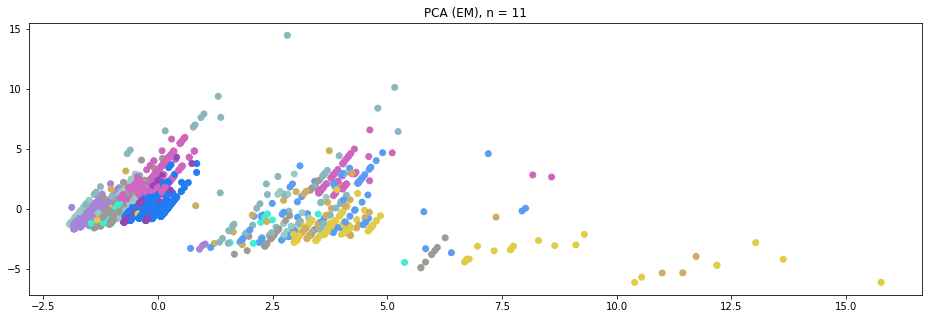

In [ ]:
n = 11
gm = GaussianMixture(n_components=n)
labels = gm.fit_predict(X)
df_labels = pd.DataFrame()
df_labels['Labels'] = labels

colors = np.sqrt(np.random.randint(0,255, size=(len(set(labels)), 3))/255)
c_arr = np.array(list(map(lambda x: colors[x], list(labels))))

plt.figure(figsize=(16,5)); plt.title('PCA (EM), n = 11')
plt.scatter(Y_pca[:, 0], Y_pca[:, 1], c=c_arr);

In [ ]:
df = df_labels
df_1 = df[(df['Labels'] == 0)]
df_2 = df[(df['Labels'] == 1)]
df_3 = df[(df['Labels'] == 2)]
df_4 = df[(df['Labels'] == 3)]
df_5 = df[(df['Labels'] == 4)]
df_6 = df[(df['Labels'] == 5)]
df_7 = df[(df['Labels'] == 6)]
df_8 = df[(df['Labels'] == 7)]
df_9 = df[(df['Labels'] == 8)]
df_10 = df[(df['Labels'] == 9)]
df_11 = df[(df['Labels'] == 10)]

data_sel11={0: df_1, 1: df_2, 2: df_3, 3: df_4, 4: df_5, 5: df_6, 6: df_7, 7: df_8, 8: df_9, 9: df_10, 10: df_11}

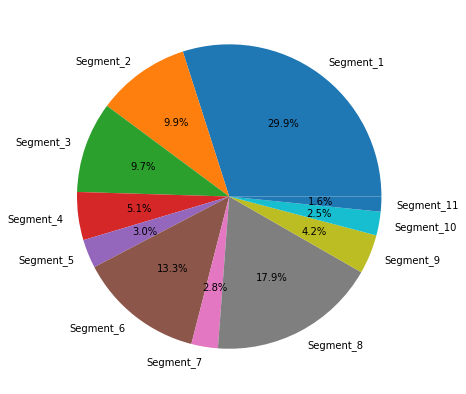

In [ ]:
fig = plt.figure(figsize =(10, 7))
data = [len(i) for i in data_sel11.values()]
labels = [('Segment_' + str(i)) for i in range(1, 12)]
plt.pie(data, labels=labels, autopct='%1.1f%%')

plt.show()